In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from prettytable import PrettyTable
from ipywidgets import interact, interactive
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

- General
- Simple data import (pressures and adsorbed amounts)
- Interactive
- Not too many charts
- Table before chart or chart before table?
- Buttons to save images to file (and tables to file?)
- Update figures to match work done on python files


1. import data, computer n(p-po) values, check adsorbent type and get ads xc area
2. check data (increasing amount adsorbed as pressure increases)
3. display conventional bet plot and data, and "best" BET range plot and data for comparison
4. BET masked heatmap
5. Interactive BET heatmap
6. Error heatmap (also interactive)
7. processed data export

## Formatting Your Data for Import

This notebook imports comma separated variable (CSV) files of a specific format. The CSV file should have two (2) columns of data, with the first row being coulmn headers. Relative pressure data in the first column and amount adsorbed [mol/g] in the second column.

The notebook is set up to import data from the 'raw_data' subdirectory.

The notebook will import the table and write all relevant data to a dataframe. The columns of the data frame, from index 0 to index 3, are: 
 - 'relp', the relative pressure of the adsorbate
 - 'n', the number of moles of adsorbate adsorbed onto the sample, solved from 'massch'
 - 'bet', the dependent term in the BET equation, $\frac{\frac{P}{P_o}}{n (1-\frac{P}{P_o})}$ setting x to the relative pressure, $x = \frac{P}{P_o}$ makes this term more neatly written as $\frac{x}{n (1-x)}$ 
 - 'check1', $n (P_o - P)$, is a value used to check the validity of BET theory over a relative pressure interval
 
After importing the data quality is checked (amount adsorbed should be increasing as relative pressure increases) and an estimation of the isotherm type is made. For information on isotherm classifcation check out: [Characterization of Porous Solids and Powders: Surface Area, Pore Size and Density](https://books.google.ca/books?id=N0r6oZ1QjMsC&lpg=PA12&ots=hk3QCpP2Vx&dq=IUPAC%20isotherm%20classification&pg=PA12#v=onepage&q=IUPAC%20isotherm%20classification&f=false)

Enter file name:slight_02_simple.csv

Isotherm data quality appears good.
Adsorbed molar amounts are increasing as relative pressure increases.

Isotherm is type II.

      relp             n          bet        check1
0   0.000  2.960000e-07     0.000000  2.960000e-07
1   0.010  1.213910e-04    83.210535  1.201771e-04
2   0.020  1.617940e-04   126.136713  1.585581e-04
3   0.030  1.946860e-04   158.860088  1.888454e-04
4   0.040  2.231390e-04   186.729647  2.142134e-04
5   0.050  2.493150e-04   211.104743  2.368492e-04
6   0.060  2.747180e-04   232.346578  2.582349e-04
7   0.070  2.987100e-04   251.979569  2.778003e-04
8   0.080  3.209260e-04   270.955054  2.952519e-04
9   0.090  3.423220e-04   288.912483  3.115130e-04
10  0.100  3.633320e-04   305.811520  3.269988e-04
11  0.125  4.120890e-04   346.665751  3.605779e-04
12  0.150  4.564980e-04   386.574724  3.880233e-04
13  0.175  4.964230e-04   427.299324  4.095490e-04
14  0.200  5.341860e-04   468.001782  4.273488e-04
15  0.225  5.687

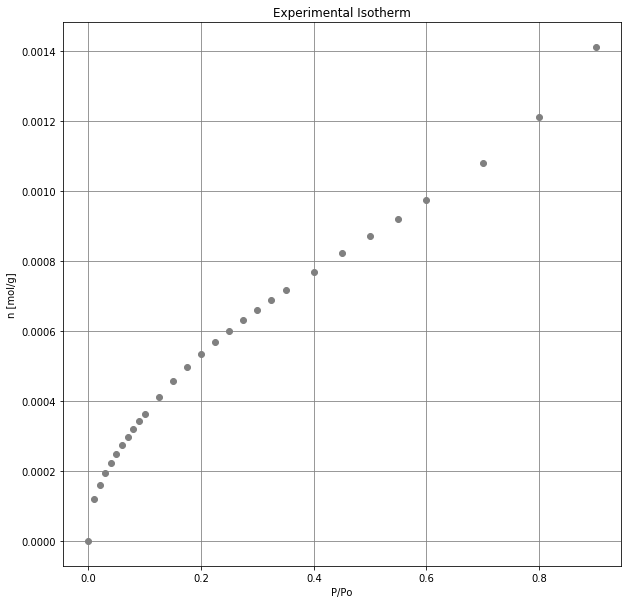

()

In [2]:
def max_min(array):
    maximum = np.nanmax(array)
    minimum = np.nanmin(array[np.nonzero(array)])
    max_idx = index_of_value(array, maximum)
    min_idx = index_of_value(array, minimum)
    return(maximum, max_idx, minimum, min_idx)


def mean_ignore0(array):
    col = array.sum(0)
    n_col = (array != 0).sum(0)
    mean = np.sum(col) / np.sum(n_col)
    return mean


def median_ignore0(array):
    m = np.ma.masked_equal(array, 0)
    median = np.ma.median(m)
    return median


def index_of_value(array, value):
    X = np.abs(array - value)
    idx = np.where(X == X.min())
    return idx


def lin_interp(df, val):
    hindex = len(df[df['n'] <= val])
    lindex = hindex - 1

    m = (df.loc[hindex, 'relp'] - df.loc[lindex, 'relp']) /\
        (df.loc[hindex, 'n'] - df.loc[lindex, 'n'])
    b = df.loc[hindex, 'relp'] - df.loc[hindex, 'n'] * m
    interp_val = m * val + b
    return interp_val

def import_data(file):
    data = pd.read_csv('raw_data/' + file)
    
    # this is all just cleaning up the imported csv data
    labels = list(data)
    data.rename(columns={labels[0]: 'relp', labels[1]: 'n'}, inplace=True)
    
    data['bet'] = data.relp / (data.n * (1 - data.relp))

    # makes a new colum of n(p0-p) aka check1 to be used in validity "mask"
    data['check1'] = data.n * (1 - data.relp)
    return data

def data_quality(df):
    """Checks the quality of the isotherm data.

    Checks data quality on the assumption that the amount adsorbed increases as
    the relative pressure of the adsorbate increases.

    Parameters
    __________
    df : dataframe
        contains adsorption data and values computed from adsortion data

    Returns
    _______
    
    printed statements concerning data quality

    """

    test = np.zeros(len(df))
    minus1 = np.concatenate(([0], df.n[: -1]))
    test = df.n - minus1
    test_sum = sum(x < 0 for x in test)
    if test_sum > 0:
        print("""\nIsotherm data is suspect.
Adsorbed moles do not consistantly increase as relative pressure increases""")
    else:
        print("""\nIsotherm data quality appears good.
Adsorbed molar amounts are increasing as relative pressure increases.""")
    return

def isotherm_type(df):
    x = df.relp.values
    y = df.n.values
    
    dist = np.sqrt((x[:-1] - x[1:])**2 + (y[:-1] - y[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    
    # build a spline representation of the contour
    spline, u = sp.interpolate.splprep([x, y], u=dist_along, w = np.multiply(1, np.ones(len(x))), s = .0000000001)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50) #len(x)
    interp_x, interp_y = sp.interpolate.splev(interp_d, spline)
    
    # take derivative of the spline (to find inflection points)
    spline_1deriv = np.diff(interp_y)/np.diff(interp_x)
    spline_2deriv = np.diff(spline_1deriv)/np.diff(interp_x[1:])
    
    zero_crossings = np.where(np.diff(np.sign(spline_2deriv)))[0]

    if len(zero_crossings) == 0 and np.sign(spline_2deriv[0]) == -1:
        print('\nIsotherm is type I.')
    elif len(zero_crossings) == 0 and np.sign(spline_2deriv[0]) == 1:
        print('\nIsotherm is type III.')
    elif len(zero_crossings) == 1 and np.sign(spline_2deriv[0]) == -1:
        print('\nIsotherm is type II.')
    elif len(zero_crossings) == 1 and np.sign(spline_2deriv[0]) == 1:
        print('\nIsotherm is type V.')
    elif len(zero_crossings) == 2 and np.sign(spline_2deriv[0]) ==-1:
        print('\nIsotherm is type IV.')
    else:
        print('\nIsotherm is type VI.')
    return

def experimental_isotherm_plot(df):
    fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(df.relp, df.n, c='grey', marker='o', linewidth=0)
    ax.set_title('Experimental Isotherm')
    ax.set_ylabel('n [mol/g]')
    ax.set_xlabel('P/Po')
    ax.grid(b=True, which='major', color='gray', linestyle='-')
    plt.show()
    return()

file = input('Enter file name:')
raw_data_df = import_data(file)

data_quality(raw_data_df)
isotherm_type(raw_data_df)

print('\n', raw_data_df)

experimental_isotherm_plot(raw_data_df)

In [3]:
adsorbate = input('Enter adsorbate name:')
ads_xc_area = float(input('Enter the adsorbed surface area of the adsorbate in square Angstrom:'))

Enter adsorbate name:etoh
Enter the adsorbed surface area of the adsorbate in square Angstrom:35.2


BET theory is typically applied to adsorption data over the relative pressure range of .05 to .35, however BET theory is not necessiarly valid over that range. More information on that may be found here: [Is-the-BET-Equation-Applicable-to-Microporous-Adsorbents.pdf](https://www.researchgate.net/profile/Jean_Rouquerol/publication/229182183_Is_the_BET_Equation_Applicable_to_Microporous_Adsorbents/links/566c2eab08ae430ab4fd3a41/Is-the-BET-Equation-Applicable-to-Microporous-Adsorbents.pdf)


We can apply BET theory over all relative possible pressure ranges, producing a heatmap where the shading of a cell corresponds to the BET specific surface area. The beginning relative pressure is read from the x-axis, the ending from the y-axis.

()

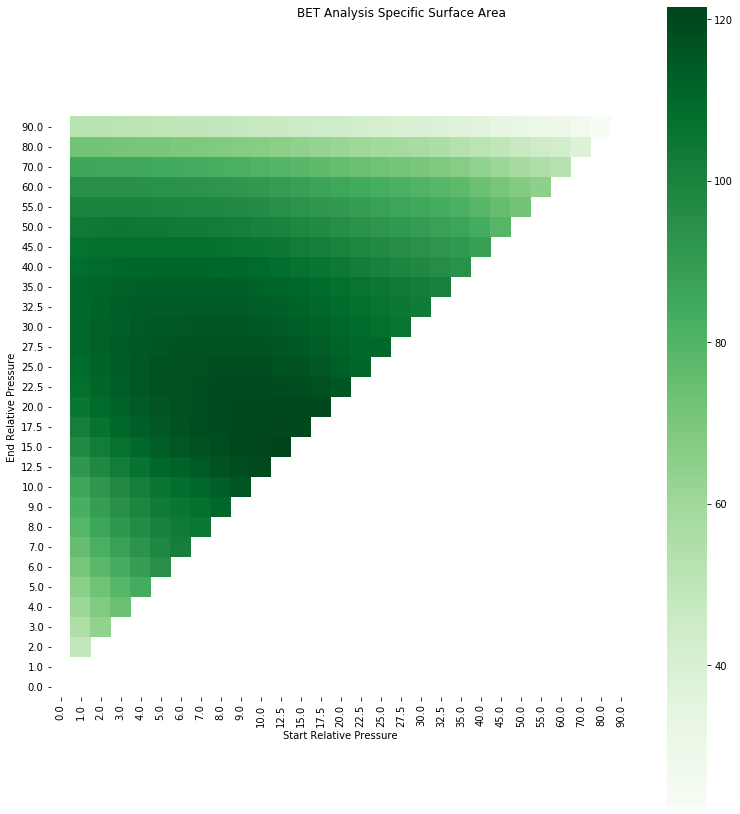

In [5]:
def bet(df, ads_xc):
    """Performs BET analysis on an isotherm data set for all relative pressure ranges.
    This is the meat and potatoes of the whole package.
    
    Parameters
    ----------
    df : dataframe
        dataframe of imported experimental isothermal adsorption data
    
    Returns
    -------
    sa_array : array
        2D array of BET specific surface areas, the coordinates of the array
        corresponding to relative pressures, units [square meter / gram]
    
    c_array : array
        2D array of BET constants, the coordinates of the array
        corresponding to relative pressures
    
    nm_array : array
        2D array of BET specific amount of adsorbate in the monolayer, the coordinates of the array
        corresponding to relative pressures, units [moles / gram]
    
    err_array : array
        2D array of error between experimental data and BET theoretical isotherms,
        the coordinates of the array corresponding to relative pressures
    
    lin_reg : array
        3D array, x by x by 3 where x is the number of experimental data points
        the x and x corrdinates corresponding to relative pressure
        this array is available for reference and BET theory checks
    
    
    """
    
    sa_array = np.zeros((len(df), len(df)))
    c_array = np.zeros((len(df), len(df)))
    nm_array = np.zeros((len(df), len(df)))
    err_array = np.zeros((len(df), len(df)))
    lin_reg = np.zeros((len(df), len(df), 3))
    i = 1  # starting at index 1 makes sure that the 0 P/Po data points used
    while i < len(df):
        j = 1
        while j < len(df) and i > j:
            a = df.iloc[j:i+1]  # check/confirm indexing "i+1"
            X = a.relp
            y = a.bet
            slope, intercept, r_value, p_value, std_err =\
                sp.stats.linregress(X, y)

            lin_reg[i, j, 0] = slope
            lin_reg[i, j, 1] = intercept
            lin_reg[i, j, 2] = r_value
            c = slope/intercept + 1
            nm = 1 / (intercept * c)
            avagadro = 6.022*10**23
            spec_sa = nm * avagadro * ads_xc * 10**-20
            sa_array[i, j] = spec_sa
            c_array[i, j] = c
            nm_array[i, j] = nm
            bet_c = np.zeros(len(df.relp))
            bet_c = (1 / (nm * c)) + (c - 1) * df.relp / (nm * c)
            errors = np.nan_to_num(abs(bet_c - df.bet))
            err_array[i, j] = sum(errors[j:i + 1]) / (i + 1 - j)
            # error is normalized for the interval of relative pressures used
            # to compute C
            # so, min and max error corresponds to the best and worst fit over
            # the interval used in BET analysis, not the entire isotherm
            j += 1
        i += 1
        np.nan_to_num(lin_reg)
    return sa_array, c_array, nm_array, err_array, lin_reg


def sa_heatmap(df, sa, file_name):
    """Creates a heatmap of specific surface areas.

    Shading corresponds to specific surface area, normalized for the minimum and maximum spec sa values.
    
    Parameters
    __________
    df : dataframe
        dataframe of imported experimental data, used to label heatmap axis

    sa : array
        array of specific surface area values, resulting from BET analysis
        if the array has had masks applied to it the resulting heatmap will be masked

    file_name : str
        file name used to import .csv data, this function uses it to name the output .png file
        
    Returns
    _______
    none

    Saves image file in same directory as figures.py code
    *CHANGE OUTPUT LOC BEFORE PACKAGING?!*

    """
    # finding max and min sa to normalize heatmap colours
    samax, sa_max_idx, samin, sa_min_idx = max_min(sa)

    hm_labels = round(df.relp * 100, 1)
    fig, (ax) = plt.subplots(1, 1, figsize=(13, 13))
    sns.heatmap(sa, vmin=samin, vmax=samax, square=True, cmap='Greens',
                mask=(sa==0), xticklabels=hm_labels, yticklabels=hm_labels)
    ax.invert_yaxis()
    plt.xlabel('Start Relative Pressure')
    plt.ylabel('End Relative Pressure')
    fig.subplots_adjust(top=.98)
    fig.suptitle('BET Analysis Specific Surface Area')
    fig.savefig('figures/ssa_heatmap_%s.png' % (file_name[:-4]), bbox_inches='tight')
    return()

sa, c, nm, err, linreg = bet(raw_data_df, ads_xc_area)
sa_heatmap(raw_data_df, sa, file)

In [ ]:


# checks that n(p-po) is increasing over BET interval
# sloppy in that it creates a mask for the whole array
# but works because of how sa array has zeros when j>=i
def check_1(df):
    """Checks that n(p-po) aka check1 is increasing over the relative pressure range used in BET analysis.
    This is a necessary condition for linearity of the BET dataset.
    
    Parameters
    __________
    df : dataframe
        dataframe of imported experimental isothermal adsorption data
    
    Returns
    _______
    mask : array
        array of 1s and 0s where 0 corresponds to relative pressure ranges where
        n(p-po) isn't consistently increasing with relative pressure
    
    """
    
    #is having mask and test arrays redundant?
    mask = np.ones((len(df), len(df)))
    minus1 = np.concatenate(([0], df.check1[: -1]))
    test = (df.check1 - minus1 >= 0)
    test = np.tile(test, (len(df), 1))
    mask = mask * test
    mask = mask.T
    return mask


# checks that y int from bet plot is positive
def check_2(lin_reg):
    """Checks that y intercept of the BET plot's fit line is positive.
    
    Parameters
    __________
    lin_reg : array
        3D array of linear regression data where [i, j, 1] contains
        y-intercept values
    
    Returns
    _______
    mask : array
        array of 1s and 0s where 0 corresponds to relative pressure ranges where
        the y-intercept is negative or zero
    """
    
    mask = (lin_reg[:, :, 1] > 0)
    return mask


# checks that nm is in range of experimental n values used in BET
def check_3(df, nm):
    """Checks that nm, amount adsorbed in the monolayer, is in the range of
    data points used in BET analysis
    
    Parameters
    __________
    df : dataframe
        dataframe of imported experimental isothermal adsorption data
    
    nm : array
        2D array of BET specific amount of adsorbate in the monolayer, the coordinates of the array
        corresponding to relative pressures, units [moles / gram]
    
    Returns
    _______
    mask : array
        array of 1s and 0s where 0 corresponds to relative pressure ranges nm is not included
        in the range of experimental n values
    """
    mask = np.ones((len(df), len(df)))
    i = 0
    while i < len(df):
        j = 0
        while j < len(df):
            if df.iloc[j, 3] <= nm[i, j] <= df.iloc[i, 3]:
                j += 1
            else:
                mask[i, j] = 0
                j += 1
        i += 1
    return mask


# checks that relp at nm and relp found from setting n = nm in BET eq agree
# sloppy in the same way as mask1
def check_4(df, lin_reg, nm):
    """Checks that relative pressure is consistent.
    The relative pressure corresponding to nm is found from linear 
    interpolation of the experiemental data. A second relative pressure is
    found by setting n to nm in the BET equation and solving for relative
    pressure. The two relative pressures are compared and must agree within 10%
    to pass this check.
    
    Parameters
    __________
    df : dataframe
        dataframe of imported experimental isothermal adsorption data
        
    lin_reg : array
        3D array of linear regression data where [i, j, 1] contains
        y-intercept values
    
    nm : array
        2D array of BET specific amount of adsorbate in the monolayer,
        the coordinates of the array corresponding to relative pressures,
        units [moles / gram]
    
    Returns
    _______
    mask : array
        array of 1s and 0s where 0 corresponds to relative pressure values that
        do not agree within 10%
    """
    mask = np.ones((len(df), len(df)))
    
    i = 1
    while i < len(df)-1:
        j = 1
        while j < len(df)-1 and nm[i,j] != 0:
            relpm = lin_interp(df, nm[i, j])
            coeff = [-1 * lin_reg[i, j, 0] * nm[i, j], lin_reg[i, j, 0]
                     * nm[i, j] - 1 - lin_reg[i, j, 1] * nm[i, j],
                     lin_reg[i, j, 1] * nm[i, j]]
            roots = np.roots(coeff)  # note: some of the roots are imaginary
            roots = [item.real for item in roots if len(roots) == 2]
            if len(roots) == 2:
                relp_m = roots[1]
                diff = (relp_m - relpm) / relpm
                if abs(diff) > .1:
                    mask[i, j] = 0
                j += 1
            else:
                j +=1
                
        i += 1
    return mask


# check that range of values used in BET contain certain number of datapoints
def check_5(df, points):
    """Checks that relative pressure ranges contain a minium number of data points.
    
    Parameters
    __________
    df : dataframe
        dataframe of imported experimental isothermal adsorption data
        
    points : int
        minimum number of data points required for BET analysis to be considered valid
        default value is 5
    
    Returns
    _______
    mask : array
        array of 1s and 0s where 0 corresponds to ranges of experimental data
        that contain less than the minimum number of points
    """
    mask = np.ones((len(df), len(df)))
    i = 0
    while i < len(df):
        j = 0
        while j < len(df):
            if i - j < points - 1:
                mask[i, j] = 0
                j += 1
            else:
                j += 1
        i += 1
    return mask

def combine_masks(df, linreg, nm):
    """Calls all check functions and combines their masks into one "combomask".
    
    Parameters
    __________
    df : dataframe
        dataframe of imported experimental isothermal adsorption data
        
    lin_reg : array
        3D array of linear regression data where [i, j, 1] contains
        y-intercept values
    
    nm : array
        2D array of BET specific amount of adsorbate in the monolayer, the coordinates of the array
        corresponding to relative pressures, units [moles / gram]
    
    Returns
    _______
    mask : array
        array of 1s and 0s where 0 corresponds to relative pressure ranges that fail one or more checks
    """
    mask1 = check_1(df)
    mask2 = check_2(linreg)
    mask3 = check_3(df, nm)
    mask4 = check_4(df, linreg, nm)
    mask5 = check_5(df, 5)

    mask = np.multiply(mask1, mask2)
    mask = np.multiply(mask3, mask)
    mask = np.multiply(mask4, mask)
    mask = np.multiply(mask5, mask)
    return mask

#mask = combine_masks(raw_data_df, linreg, nm)
#masked_sa = np.multiply(sa, mask)


def mask_picker(df, linreg, sa, nm, c1, c2, c3, c4, c5, c5_points):
    if c1 == True:
        mask1 = check_1(df)
    else:
        mask1 = np.ones((len(df), len(df)))
        
    if c2 == True:
        mask2 = check_2(linreg)
    else:
        mask2 = np.ones((len(df), len(df)))
        
    if c3 == True: 
        mask3 = check_3(df, nm)
    else:
        mask3 = np.ones((len(df), len(df)))
        
    if c4 == True:    
        mask4 = check_4(df, linreg, nm)
    else:
        mask4 = np.ones((len(df), len(df)))
        
    if c5 == True:  
        mask5 = check_5(df, c5_points)
    else:
        mask5 = np.ones((len(df), len(df)))
    mask = np.ones((len(df), len(df)))
    #mask = np.tril(mask, -1)
    mask = np.multiply(mask1, mask)
    mask = np.multiply(mask2, mask)
    mask = np.multiply(mask3, mask)
    mask = np.multiply(mask4, mask)
    mask = np.multiply(mask5, mask)
    return(mask)  

def plotting(Check_1=True, Check_2=True, Check_3=True, Check_4=True, Check_5=True, Min_Points=5):
    global custom_mask 
    custom_mask = mask_picker(df, linreg, sa, nm, Check_1, Check_2, Check_3, Check_4, Check_5, Min_Points)
    ssa = np.multiply(sa, custom_mask)
    ssa = np.nan_to_num(ssa)

    # finding max and min sa to normalize heatmap colours
    samax, sa_max_idx, samin, sa_min_idx = max_min(ssa)

    # BET constant with all masks applied
    c_masked = np.multiply(c, custom_mask)
    c_masked = np.nan_to_num(c_masked)

    # error with all masks applied, useful in comparing values of C
    err_masked = np.multiply(err, custom_mask)
    err_masked = np.nan_to_num(err_masked)
    
    hm_labels = round(df.relp * 100, 1)
    fig, (ax) = plt.subplots(1, 1, figsize=(13, 13))
    sns.heatmap(ssa, vmin=samin, vmax=samax, square=True, cmap='Greens', mask=(ssa==0),
                xticklabels=hm_labels, yticklabels=hm_labels)
    ax.invert_yaxis()
    plt.xlabel('Start Relative Pressure')
    plt.ylabel('End Relative Pressure')
    fig.subplots_adjust(top=.98)
    fig.suptitle('BET Analysis Specific Surface Area')
    fig.savefig('figures/custom_ssa_heatmap_%s.png' % (file[:-4]), bbox_inches='tight')
    plt.show()
    
interactive_heatmap = interactive(plotting, Check_1=False, Check_2=False, Check_3=False, Check_4=False, Check_5=False, Min_Points = (1,len(df),1))
interactive_heatmap

In [ ]:
def export_raw_data(df, file_name):
    file_name = file_name[:-4]
    export_file_name = 'output/' + file_name + '_raw_data_export.csv'
    export_csv = df.to_csv(export_file_name, index=None, header=True)
    return

def export_processed_data(df, sa, c, nm, lin_reg, file_name):
    i = 0
    end_relp = np.zeros((len(df), len(df)))
    while i < len(df):
        end_relp[i:] = df.relp[i]
        i += 1

    begin_relp = np.transpose(end_relp)

    mask1 = check_1(df)
    mask2 = check_2(lin_reg)
    mask3 = check_3(df, nm)
    mask4 = check_4(df, lin_reg, nm)

    processed_data = np.column_stack((begin_relp.flatten(), end_relp.flatten()))
    processed_data = np.column_stack((processed_data, sa.flatten()))
    processed_data = np.column_stack((processed_data, c.flatten()))
    processed_data = np.column_stack((processed_data, nm.flatten()))
    processed_data = np.column_stack((processed_data, lin_reg[:,:,0].flatten()))
    processed_data = np.column_stack((processed_data, lin_reg[:,:,1].flatten()))
    processed_data = np.column_stack((processed_data, lin_reg[:,:,2].flatten()))
    processed_data = np.column_stack((processed_data, mask1.flatten()))
    processed_data = np.column_stack((processed_data, mask2.flatten()))
    processed_data = np.column_stack((processed_data, mask3.flatten()))
    processed_data = np.column_stack((processed_data, mask4.flatten()))
    
    processed_data = pd.DataFrame(data=processed_data, columns=['begin relative pressure', 'end relative pressure', 'spec sa [m2/g]',
              'bet constant', 'nm [mol/g]', 'slope', 'y-int', 'r value', 'check1',
              'check2','check3','check4'])

    file_name = file_name[:-4]
    export_file_name = 'output/' + file_name + '_processed_data_export.csv'
    export_csv = processed_data.to_csv(export_file_name, index=None, header=True)

    return processed_data


def export_data(Raw_data = False, Processed_data = False):
        
    if Raw_data == True:
        export_raw_data(df, file)
        
    if Processed_data == True:
        export_processed_data(df, sa, c, nm, linreg, file)
        
    return()

export_data_buttons = interactive(export_data, Raw_data = False, Processed_data = False)
export_data_buttons